# MLIP fitting workflow

This notebook walks though a lightweight workflow of fitting a MLIP to showcase usage of a wide range of wfl functions and ways they can be used. 

The main steps are: 

1. Create some molecules
2. Run GFN2-xTB MD
3. Filter by force components
4. Calculate global SOAP descriptor
5. Perform CUR decomposition to select diverse-ish training and testing sets
6. Fit a GAP potential
7. Evaluate structures with GAP
8. Plot atomization energy and force component correlation plots. 


## Imports 

In addition to standard packages or wfl dependencies, we make use of three external packages: 

- quip and quippy which provide interface for fitting and evaluating GAP. 
  
  Documentation: https://pypi.org/project/quippy-ase/ 
  
  Installation: `pip install quippy-ase`


- GFN2-xTB: a semi-empirical method designed for molecular systems, used as a reference method. 

  Documentation: 
  - https://xtb-docs.readthedocs.io/en/latest/contents.html
  - https://xtb-python.readthedocs.io/en/latest/

  Installation: `conda install -c conda-forge xtb-python`

- RDKit: a chemoinformatics package that wfl uses to convert 2D SMILES strings (e.g. "CCO" for ethanol) into 3D `Atoms` objects. 

  Documentation: https://rdkit.org/

  Installation: `conda install -c conda-forge rdkit`


In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from ase.io import read, write
from ase import Atoms

from xtb.ase.calculator import XTB

from quippy.potential import Potential

from wfl.configset import ConfigSet, OutputSpec
from wfl.generate import md
import wfl.descriptors.quippy
import wfl.select.by_descriptor
import wfl.fit.gap.simple
from wfl.calculators import generic
from wfl.autoparallelize.autoparainfo import AutoparaInfo
from wfl.autoparallelize.remoteinfo import RemoteInfo
from wfl.generate import smiles
from wfl.utils.configs import atomization_energy
from wfl.fit import error
from wfl.select.simple import by_bool_func

from expyre.resources import Resources

## Reference calculator 

The calculator object given to `autoparalellize`-wrapped functions need to be pickle-able, so it can be executed on the parallel Python subprocesses with `multiprocessing.pool`. The calculators that can't be pickled need to be given to workflow functions as 

`(Initalizer, [args], {kwargs})`

e.g. xtb would normally be called with 

`xtb_calc = XTB(method="GFN2-xTB")`

but instead in wfl scripts we define it as

In [5]:
xtb_calc = (XTB, [], {"method": "GFN2-xTB"})

## Prepare isolated atoms 

GAP requires reference (`e0`) energies for fitting. We construct `Atoms` objects with a single atom, evaluate them with the reference GFN2-xTB method and store in a file to later combine them with the training set. 

In [11]:
isolated_at_fname='isolated_atoms.xtb.xyz'
isolated_at = [Atoms(element, positions=[(0, 0, 0)]) for element in ["H", "C"]]
inputs = ConfigSet(isolated_at)
outputs = OutputSpec()

inputs = generic.run(
    inputs=inputs,
    outputs=outputs,
    calculator=xtb_calc,
    properties=["energy"],
    output_prefix="xtb_"
)

outputs = OutputSpec(isolated_at_fname)
for at in inputs:
    # GAP needs a cell for fitting, even for non-periodic structures.
    at.cell = [50,50,50]
    # set config_type for `gap_fit` to recognise the appropriate frames.  
    at.info["config_type"] = "isolated_atom"
    outputs.store(at)
outputs.close()

## Generate initial structures

We build this example on a small number of hydrocarbon molecules. Their connectivity is represented as SMILES strings and use RDKit to them into reasonable 3D geometries to start the molecular dynamics simulation with. 

In [6]:
all_smiles = [
    'CC1=CCC=CC(C)=C1C(C)C', 
    'CC1(c2ccc(CC3CC=CC3)cc2)CC1', 
    'C#CC[C@@H](CCC=C(C)C)C1CC1', 
    'Cc1ccccc1CCCC1=CCCCC1', 
    'C=CC1=CC[C@@H]2C[C@H]1C2(C)C', 
    'C1=CCC(Cc2ccc(CC3CC3)cc2)C1', 
    'C1=CC(c2ccccc2)=CCC1', 
    'C/C=C/CCCC[C@H](C)C(C)(C)C', 
    'C=C[C@@H]1C/C=C/CCCCCCCC1', 
    'C[C@H](CC(C)(C)C)[C@@H](C)C(C)(C)C', 
    'CC/C=C\\C[C@@H](C)c1cccc(C)c1C', 
    'C=C1CC2c3ccccc3C1c1ccccc12']

outputs = OutputSpec("1.ch.rdkit.xyz")
inputs = smiles.run(all_smiles, outputs=outputs)

## Run Molecular Dynamics simulation

We run the MD at 300 K with an NVT Berendsen thermostat. 

 TODO: how do we manage remote execution examples code-testing-wise?

In [7]:
outputs = OutputSpec("2.ch.rdkit.md.traj.xyz")

md_params = {
    "steps": 80,
    "dt": 0.5,  # fs
    "temperature": 300,  # K
    "temperature_tau": 500,  
    "results_prefix": "xtb_",
    "traj_step_interval": 5}

remote_info = {
    "sys_name" : "local", 
    "job_name" : "md", 
    "resources" : { 
        "max_time" : "15m",
        "num_cores" : 4,
        "partitions" : "any$"}, 
    "partial_node": True,
    "check_interval": 5,
    "num_inputs_per_queued_job" :20,
    "pre_cmds" :["conda activate dev"]
}


Creating job md_chunk_0
ExPyRe md_chunk_0 constructor done stage in files 1675187004.1068766
Starting job for md_chunk_0_wwv-BW3fpA41qkNP23A5vAqOoZXuw6OXgeKRWgt0CQ8=_s95p1ub6
Gathering results for md_chunk_0_wwv-BW3fpA41qkNP23A5vAqOoZXuw6OXgeKRWgt0CQ8=_s95p1ub6 remote 205293
Waiting for job md_chunk_0_wwv-BW3fpA41qkNP23A5vAqOoZXuw6OXgeKRWgt0CQ8=_s95p1ub6 up to 3600 s: 
qqrr
Running wfl.generate.md._sample_autopara_wrappable with num_python_subprocesses=4, num_inputs_per_python_subprocess=1


In [ ]:
# set to None for github testing purposes
# This cell is hidden from being rendered in the docs. 
remote_info = None


In [ ]:
inputs = md.sample(
    inputs=inputs, 
    outputs=outputs,
    calculator=xtb_calc,
    autopara_info = AutoparaInfo(
        remote_info=remote_info),
    **md_params
    )


## Filter out unreasonable structures

While diverse training set leads to better model extrapolation, structures too dissimilar to the region of interest are fitted at the expense of accuracy elsewhere. One way to spot structures somewhat distant from equilibrium is by checking for high force components. Below we exclude such structures via one of wfl's filtering functions. 

In [8]:

def are_xtb_force_comps_reasonable(at):
    force_comps = at.arrays["xtb_forces"]
    return np.all(np.abs(force_comps) < 8 )

outputs = OutputSpec("3.ch.rdkit.md.traj.filtered.xyz") 
inputs = by_bool_func(
    inputs = inputs, 
    outputs = outputs,
    at_filter = are_xtb_force_comps_reasonable
)


## Calculate SOAP descriptor

In [9]:
tmp_outputs = OutputSpec()
outputs = OutputSpec("4.ch.rdkit.md.traj.filtered.soap.xyz")

# a nice feature of `ConfigSet`: 
# can check if output from this step is already created and not re-execute it
if outputs.done():
    print("Not calculating SOAP, because output file is found")
    inputs = outputs.to_ConfigSet()
else:
    descriptor_key = "SOAP"
    # Descriptor string, just as it would go into quip.
    # dictionary can have a descriptor per species, e.g. 
    # descriptor = {
    #   "H": "soap ...",
    #   "C": "soap ..."}
    # `None` for dictionary keys just means that the same descriptor is used 
    # for all elements. 
    descriptor =   {
            None: "soap l_max=3 n_max=6 cutoff=4 delta=1 covariance_type=dot_product zeta=4 atom_gaussian_width=0.3"
        }

    # this function isn't parallelised here, but can be
    # by setting WFL_NUM_PYTHON_SUBPROCESSES or
    # WFL_EXPYRE_INFO
    inputs = wfl.descriptors.quippy.calc(
        inputs=inputs,
        outputs=tmp_outputs,
        descs=descriptor,
        key=descriptor_key,
        per_atom=True
    )

    # make global average descriptor out of local ones
    for at in inputs:
        at_desc = at.arrays.pop(descriptor_key)
        at_desc = np.sum(at_desc, axis=0)
        at_desc /= np.linalg.norm(at_desc)
        at.info[descriptor_key] = at_desc
        outputs.store(at)
    outputs.close()
    inputs = outputs.to_ConfigSet()

## Sub-select with CUR

Select diverse structures for training and testing sets with CUR. 

In [12]:
outputs = OutputSpec("5.ch.rdkit.md.traj.soap.cur_selection.xyz")
inputs = wfl.select.by_descriptor.CUR_conf_global(
    inputs=inputs,
    outputs=outputs,
    num=100,                    # target number of environments to pick
    at_descs_info_key="SOAP"
)

train_fname = "6.1.train.xyz"
test_fname = "6.2.test.xyz"
gap_fname='gap.xml'

# process configs before fitting
inputs = list(inputs)
for at in inputs:

    # set the cell for gap_fit
    at.cell = [50, 50, 50]

    # gap_fit cannot parse the xyz correctly with the SOAP descriptor
    # in the info line, so let's delete it
    del at.info["SOAP"]

write(train_fname, inputs[0::2] + read(isolated_at_fname, ":"))
write(test_fname, inputs[1::2])

/home/eg475/dev/workflow/wfl/select/by_descriptor.py:197: UserWarning: output is done, returning
  warnings.warn('output is done, returning')


## Fit GAP

The gap parameter dictionary is almost directly converted to a command for `gap_fit`. 

In [13]:

gap_params = {
    "gap_file": gap_fname,
    "energy_parameter_name": "xtb_energy", 
    "force_parameter_name": "xtb_forces", 
    "default_sigma": [0.001, 0.01, 0.0, 0.0], 
    "config_type_kernel_regularisation": {"isolated_atom":[0.0001,0.0001,0.0,0.0]},
    "_gap": [{
            "soap": True,
            "l_max": 3,
            "n_max": 6, 
            "cutoff": 3,
            "delta": 0.1,
            "covariance_type": "dot_product",
            "zeta": 4, 
            "n_sparse":20, 
            "sparse_method": "cur_points", 
            "atom_gaussian_width":0.3,
            "cutoff_transition_width": 0.5},
         {
            "soap": True,
            "l_max": 3,
            "n_max": 6, 
            "cutoff": 6,
            "delta": 0.1,
            "covariance_type": "dot_product",
            "zeta": 4, 
            "n_sparse":20, 
            "sparse_method": "cur_points", 
            "atom_gaussian_width":0.6,
            "cutoff_transition_width": 1},
        {
            "distance_2b": True,
            "cutoff": 7, 
            "covariance_type": "ard_se",
            "delta": 1,
            "theta_uniform": 1.0,
            "sparse_method": "uniform", 
            "n_sparse": 10 
        }
    ]
}

remote_info = {
    "sys_name" : "local", 
    "job_name" : "gap-fit", 
    "resources" : { 
        "max_time" : "15m",
        "num_cores" : 4,
        "partitions" : "any$"}, 
    "partial_node": True,
    "check_interval": 5, 
    "pre_cmds" :["conda activate dev"],
}


ExPyRe gap-fit constructor done stage in files 1675187790.250353
Waiting for job gap-fit_PQSQjT49J8zLFRj-1yWYicizXoJaUmD5EkFjy7SM2bI=_3sfc8kno up to 3600 s: 
qr
copying _gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4791 gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4791
copying _gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4792 gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4792
copying _gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4793 gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4793
copying _gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4794 gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4794
copying _gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4795 gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4795
copying _gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4796 gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4796
copying _gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4797 gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4797
Deleting _gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4791
Deleting _gap.xml.sparseX.GAP_2023_1_31_0_17_57_33_4792
Deleting _gap.xml.sp

fitting command:
 gap_fit gap_file=_gap.xml energy_parameter_name=xtb_energy force_parameter_name=xtb_forces sparse_separate_file=T default_sigma={0.001 0.01 0.0 0.0} config_type_kernel_regularisation=isolated_atom:0.0001:0.0001:0.0:0.0 atoms_filename=/tmp/205297.1.any/_GAP_fitting_configs.__b95imi.xyz gap={ soap=T l_max=3 n_max=6 cutoff=3 delta=0.1 covariance_type=dot_product zeta=4 n_sparse=20 sparse_method=cur_points atom_gaussian_width=0.3 cutoff_transition_width=0.5 : soap=T l_max=3 n_max=6 cutoff=6 delta=0.1 covariance_type=dot_product zeta=4 n_sparse=20 sparse_method=cur_points atom_gaussian_width=0.6 cutoff_transition_width=1 : distance_2b=T cutoff=7 covariance_type=ard_se delta=1 theta_uniform=1.0 sparse_method=uniform n_sparse=10 } 2>&1 > _gap_fit.out 


In [ ]:
# set to None for github testing purposes
# This cell is hidden from being rendered in the docs. 
remote_info = None

In [ ]:
if not Path(gap_fname).exists(): 
    wfl.fit.gap.simple.run_gap_fit(
        fitting_configs=ConfigSet(train_fname),
        fitting_dict=gap_params,
        stdout_file='gap_fit.out',
        remote_info=remote_info
)

## Evaluate structures with GAP

In [14]:
train_fn_with_gap = "7.1.train.gap.xyz"
test_fn_with_gap = "7.2.test.gap.xyz"
isolated_at_fn_with_gap = isolated_at_fname.replace('.xyz', '.gap.xyz')

inputs = ConfigSet([train_fname, test_fname, isolated_at_fname])
outputs = OutputSpec([train_fn_with_gap, test_fn_with_gap, isolated_at_fn_with_gap])

gap_calc = (Potential, [], {"param_filename":"gap.xml"})

resources = Resources(
    max_time = "15m",
    num_cores = 2,
    partitions = "any$")

remote_info = RemoteInfo(
    sys_name = "local",
    job_name = "gap-eval",
    resources = resources,
    partial_node = True,
    check_interval=10, 
    input_files=["gap.xml*"], 
    pre_cmds = ["conda activate dev"])


Creating job gap-eval_chunk_0
ExPyRe gap-eval_chunk_0 constructor done stage in files 1675187827.7335908
Starting job for gap-eval_chunk_0_K8keKHhDDJYZoF_g1D9XVyzdTVB0Q39FD2PAuYt3m6g=_z15waxoz
Gathering results for gap-eval_chunk_0_K8keKHhDDJYZoF_g1D9XVyzdTVB0Q39FD2PAuYt3m6g=_z15waxoz remote 205298
Waiting for job gap-eval_chunk_0_K8keKHhDDJYZoF_g1D9XVyzdTVB0Q39FD2PAuYt3m6g=_z15waxoz up to 3600 s: 
r
Running wfl.calculators.generic._run_autopara_wrappable with num_python_subprocesses=2, num_inputs_per_python_subprocess=10


In [ ]:
# Set remote_info to None so that this can run on GitHub CI. 
# This cell is hidden from being rendered in the docs. 
remote_info = None

In [ ]:

gap_calc_autopara_info = AutoparaInfo(
    remote_info=remote_info)

generic.run(
    inputs=inputs,
    outputs=outputs,
    calculator=gap_calc,
    properties=["energy", "forces"],
    output_prefix="gap_",
    autopara_info=gap_calc_autopara_info,
    )


## Evaluate error & plot correlation

wfl has simple convenience functions to compare fitted model's performance to the reference method. Here we calculate atomization energy, evaluate RMSE and plot the parity plots for atomization energy per atom and force components. 

/home/eg475/dev/workflow/wfl/utils/configs.py:73: UserWarning: Ouput for atomization energy (<wfl.configset.OutputSpec object at 0x7fc6d757cb50>) are done, not recomputing.
  warnings.warn(f"Ouput for atomization energy ({outputs}) are done, not recomputing.")
/home/eg475/dev/workflow/wfl/utils/configs.py:73: UserWarning: Ouput for atomization energy (<wfl.configset.OutputSpec object at 0x7fc68805cf10>) are done, not recomputing.
  warnings.warn(f"Ouput for atomization energy ({outputs}) are done, not recomputing.")


      atomization_energy/a atomization_energy/a    F/c    F/c
                    meV/at                    #  meV/Å      #
test                 18.29                   50 741.65   5049
train                19.15                   50 713.26   5007
_ALL_                18.72                  100 727.65  10056


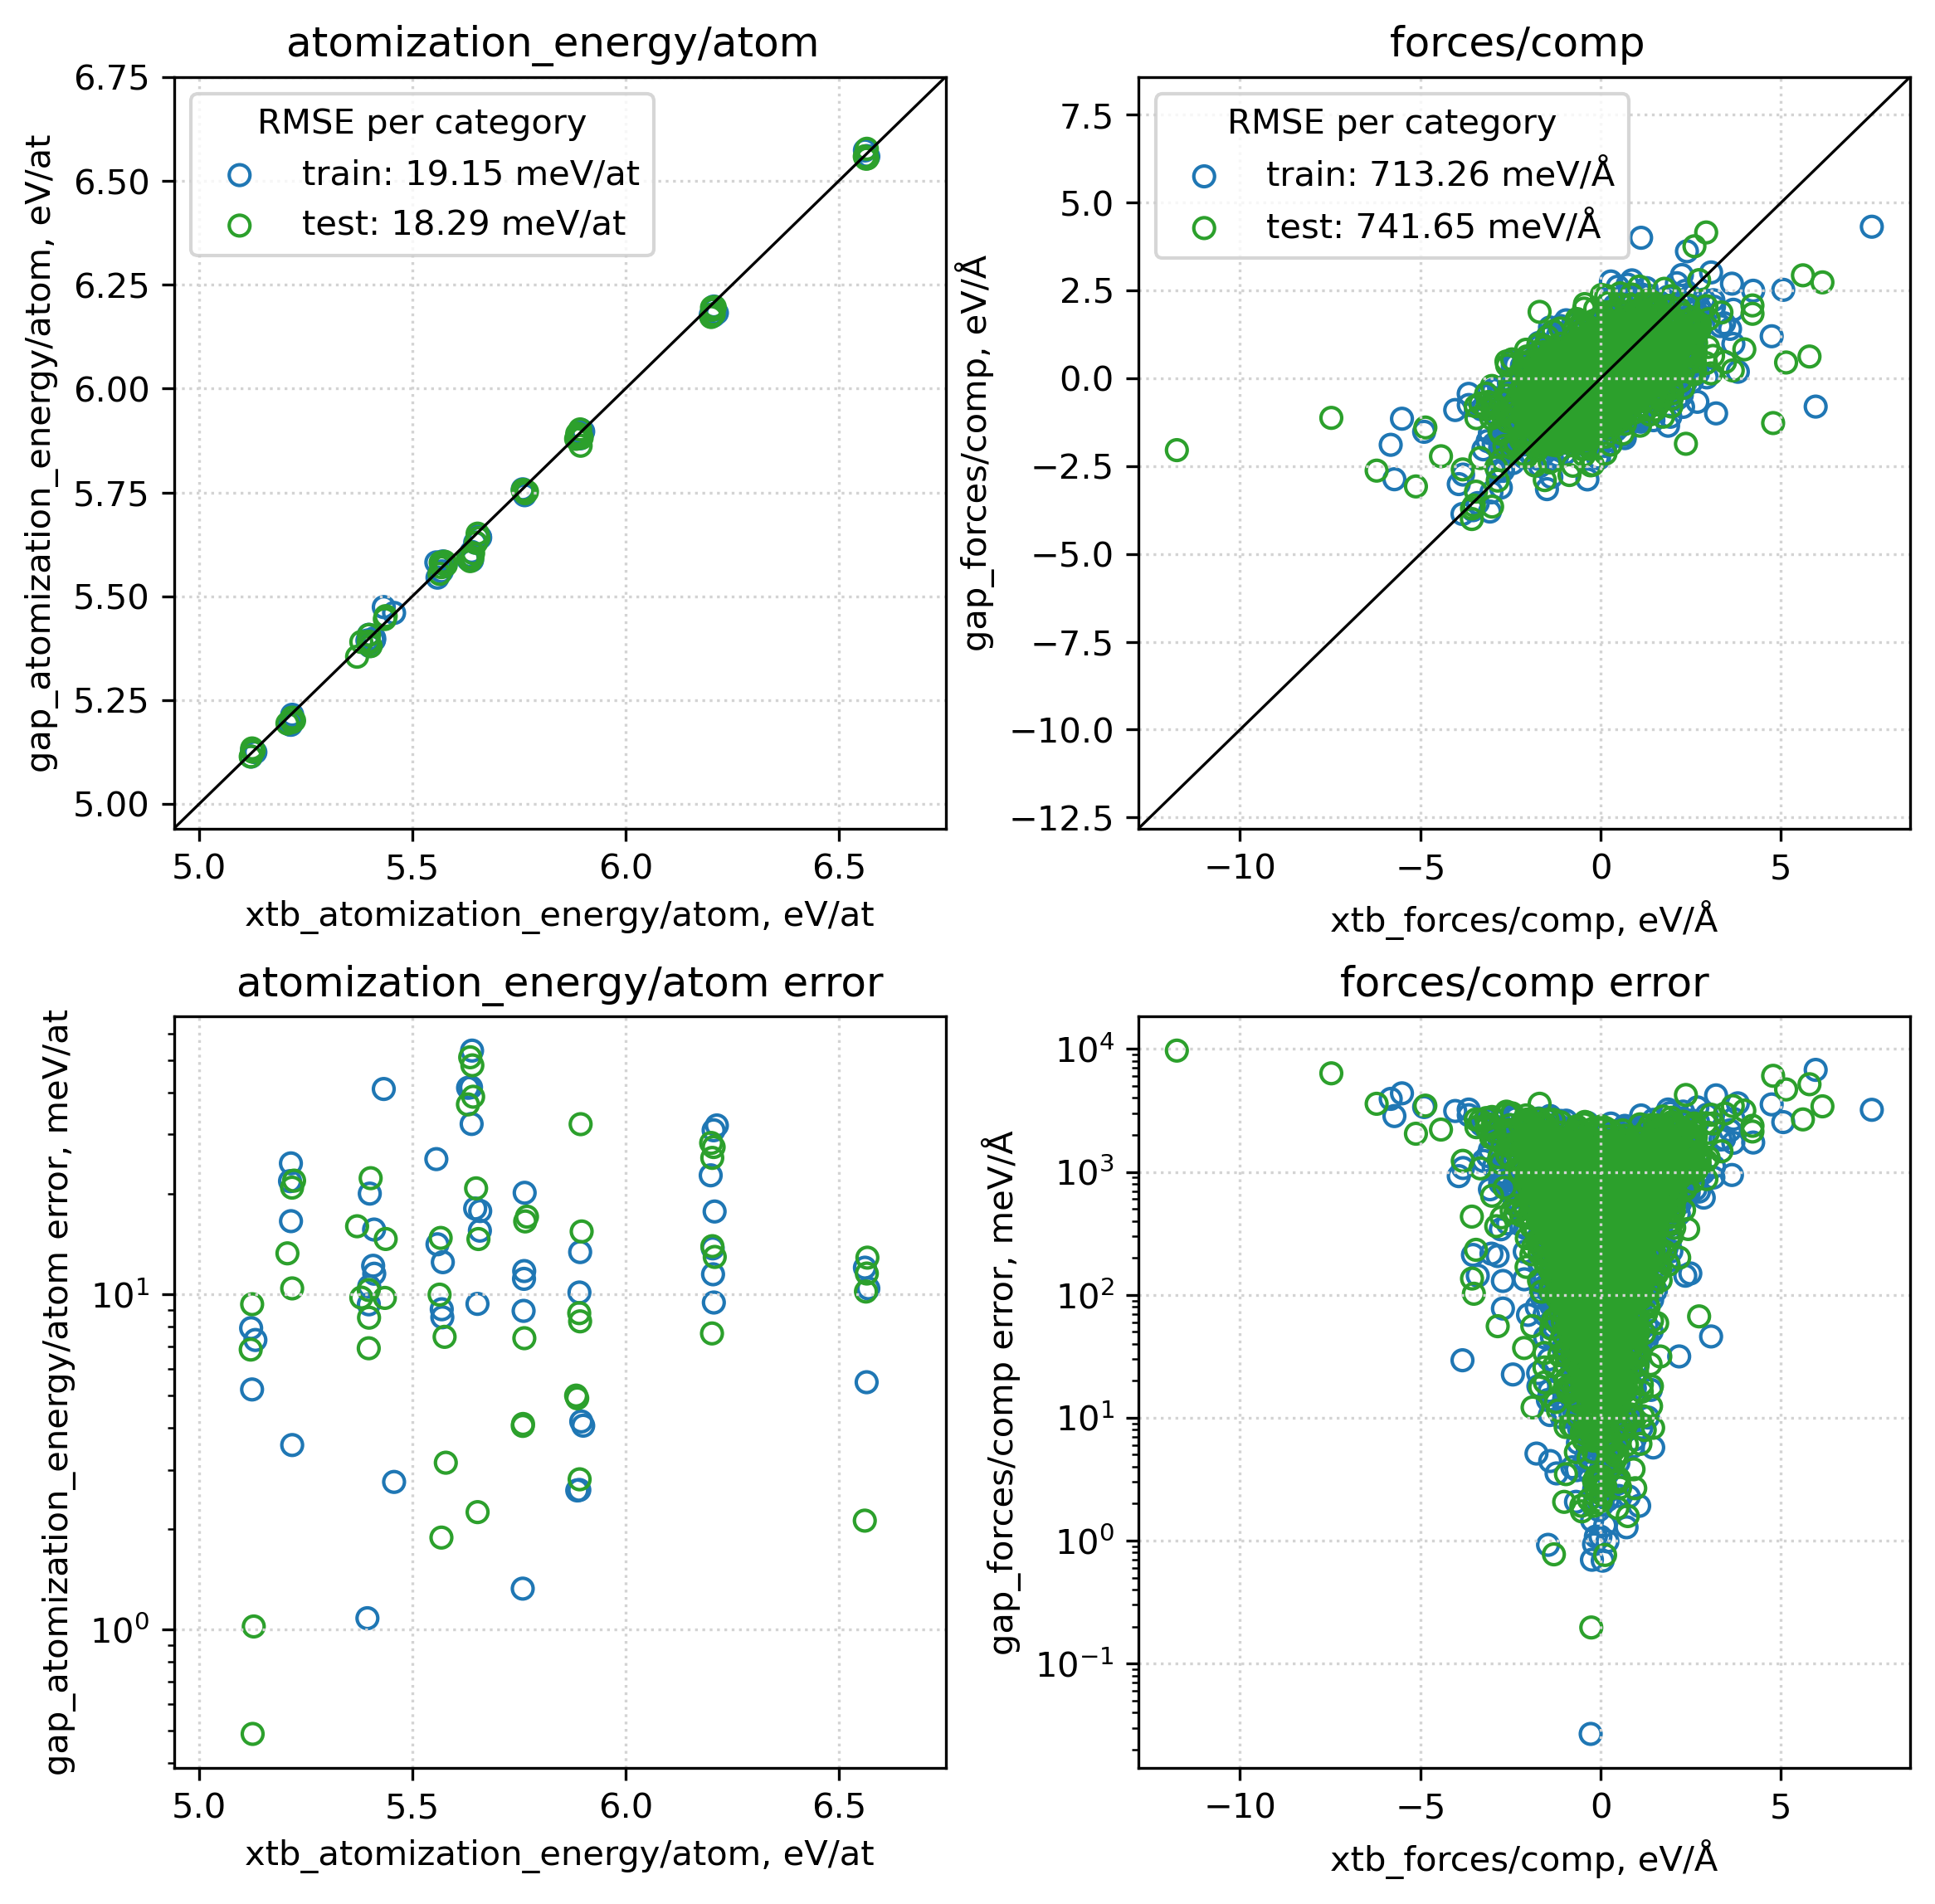

In [18]:
train_ae_fn = "8.1.train.gap.ae.xyz"
test_ae_fn = "8.2.test.gap.ae.xyz"

for label, ae_fn, fn in zip(["train", "test"], [train_ae_fn, test_ae_fn], [train_fn_with_gap, test_fn_with_gap]):

    if label == "test":
        inputs = ConfigSet([fn, isolated_at_fn_with_gap])
    else:
        inputs = ConfigSet(fn)
    outputs = OutputSpec()

    inputs = atomization_energy(
        inputs=inputs, 
        outputs=outputs, 
        prop_prefix="xtb_")

    outputs = OutputSpec(ae_fn)
    inputs = atomization_energy(
        inputs=inputs, 
        outputs=outputs, 
        prop_prefix="gap_")

    ats = read(ae_fn, ":")
    ats_out = []
    for at in ats:
        if at.info["config_type"] == "isolated_atom":
            continue
        at.info["config_type"] = label
        ats_out.append(at)
    write(ae_fn, ats_out)

inputs = ConfigSet([train_ae_fn, test_ae_fn])

errors, diffs, parity = error.calc(
    inputs=inputs, 
    calc_property_prefix='gap_',
    ref_property_prefix='xtb_',
    config_properties=["atomization_energy/atom"],
    atom_properties=["forces/comp"])

print(error.errors_dumps(errors))

error.value_error_scatter(
    all_errors = errors, 
    all_diffs=diffs,
    all_parity=parity,
    output="gap_rmses.png",
    ref_property_prefix="xtb_",
    calc_property_prefix="gap_"
)


In [ ]:
from pathlib import Path

# just check that all the files are there, so all steps completed (successfully). 

expected_files = [
    "isolated_atoms.xtb.xyz",
    "1.ch.rdkit.xyz",
    "2.ch.rdkit.md.traj.xyz",
    "3.ch.rdkit.md.traj.filtered.xyz",
    "4.ch.rdkit.md.traj.filtered.soap.xyz",
    "5.ch.rdkit.md.traj.soap.cur_selection.xyz",
    "6.1.train.xyz"
    "6.2.test.xyz",
    "gap.xml",
    "7.1.train.gap.xyz",
    "7.2.test.gap.xyz",
    "8.1.train.gap.ae.xyz",
    "8.2.test.gap.ae.xyz"
    "gap_rmses.png"
]

for file in expected_files:
    assert Path(file).exists()